In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import scipy

from sklearn.linear_model import Ridge

import child_poverty_iraq.data.load_data as ld
import child_poverty_iraq.models.train_model as tm
import child_poverty_iraq.models.evaluate_model as em
import child_poverty_iraq.models.predict_model as pm


# Load data

In [10]:
target = 'dep_sanitation_sev'
target_name = 'Sanitation'

cmap = 'YlGn'

In [2]:
merged = ld.make_dataset_ADM1(all_dims=True)

Mosaiks shape: (2849, 4001)
The file '../data/external/geoBoundariesCGAZ_ADM1.topojson' exists.


Geometry shape: (3291, 9)
(2849, 4010)
Number of obs with missing geometry: 1
(2848, 4010)
Poverty shape: (1071, 27)


100%|██████████| 176/176 [00:19<00:00,  9.00it/s]


Geometry shape: (2554, 5)
Poverty + geometry shape: (1071, 32)
(6492, 4044)
(981, 4048)


In [4]:
merged[target] = merged[target]*100

<Axes: xlabel='dep_sanitation_sev', ylabel='Count'>

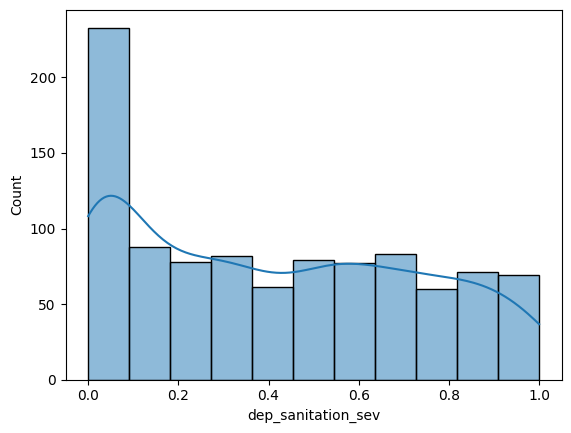

In [11]:
sns.histplot(merged[target], kde=True)

In [7]:
irq_adm1 = merged[merged['countrycode']=='IRQ'].copy()
print(irq_adm1.shape)

(18, 4048)


In [12]:
irq_adm1[target].describe()

count    18.000000
mean      0.019051
std       0.025873
min       0.000000
25%       0.001563
50%       0.008097
75%       0.020536
max       0.085276
Name: dep_sanitation_sev, dtype: float64

# Model

In [13]:
pred_amd1, model, model_details, performance = tm.train_model(merged, target=target, 
                                   model = Ridge(0.5),
                                   boxcox=False, pca_components=300, weight=25, plot=False)

print(performance)

y_train_pred = pred_amd1[pred_amd1['is_training']==1]['predictions']
y_train = pred_amd1[pred_amd1['is_training']==1][target]
y_test_pred = pred_amd1[pred_amd1['is_training']==0]['predictions']
y_test = pred_amd1[pred_amd1['is_training']==0][target]

{'r2_cv': 0.4203435721713892, 'r2_cv_sd': 0.1553279457152291, 'r2_train': 0.8019360503347233, 'r2_test': 0.4839027341891162}


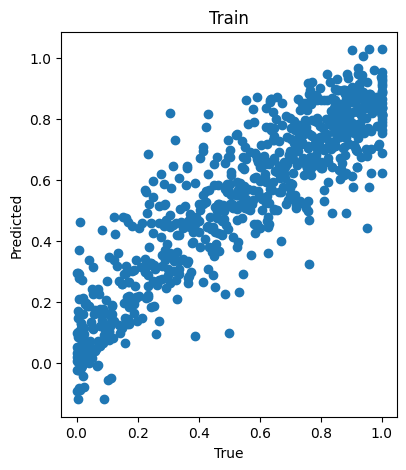

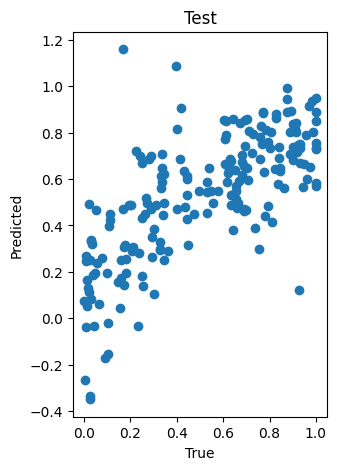

In [17]:
em.scatter_plot(y_train_pred, y_train, y_test, y_test_pred)

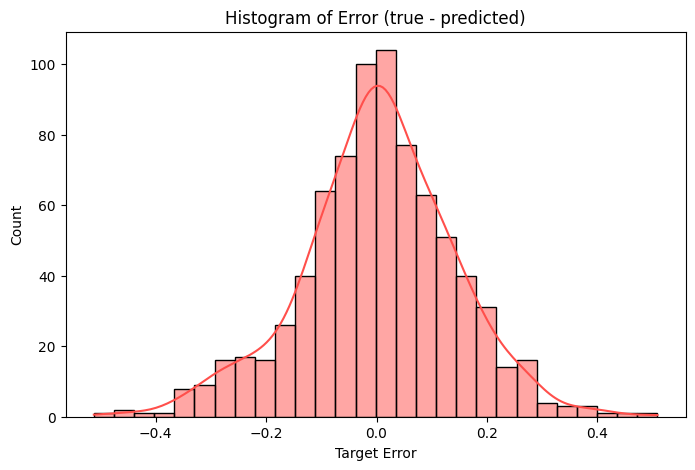

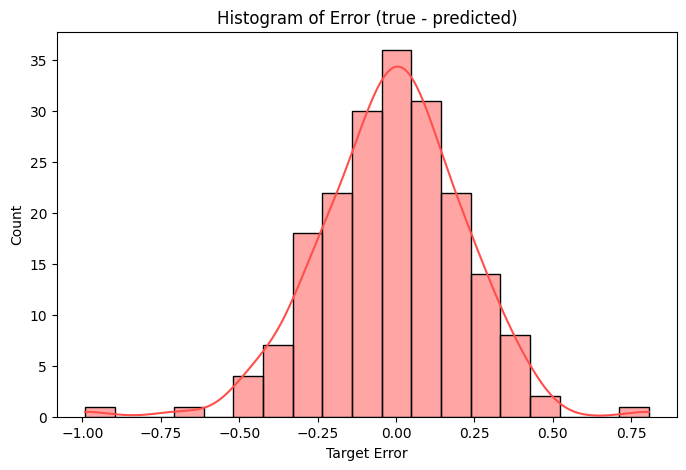

In [18]:
em.hist_errors(y_train_pred, y_train, y_test, y_test_pred)

The file '../data/external/geoBoundariesCGAZ_ADM0.topojson' exists.


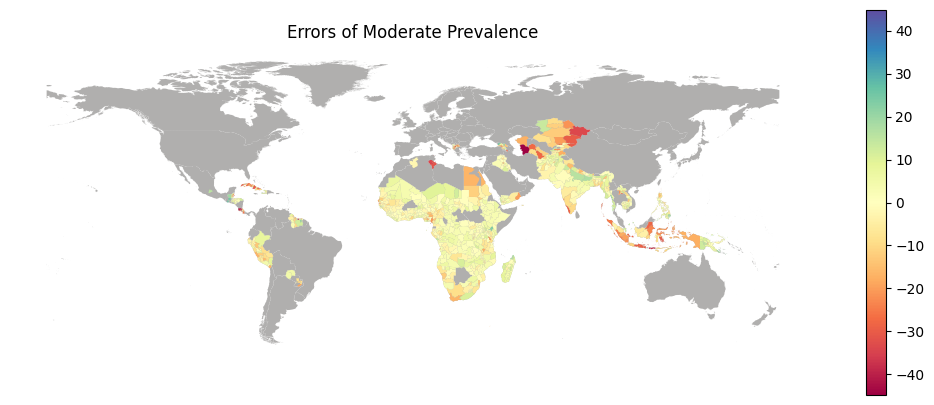

In [ ]:
em.map_errors(pred_amd1, col_to_plot="target_error")

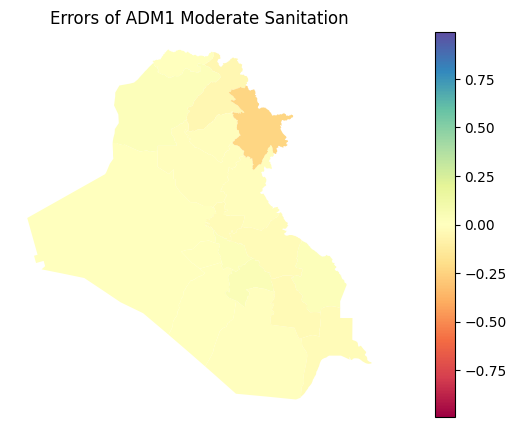

In [19]:
em.map_irq_error(pred_amd1, col_to_plot="target_error", target_name=target_name)

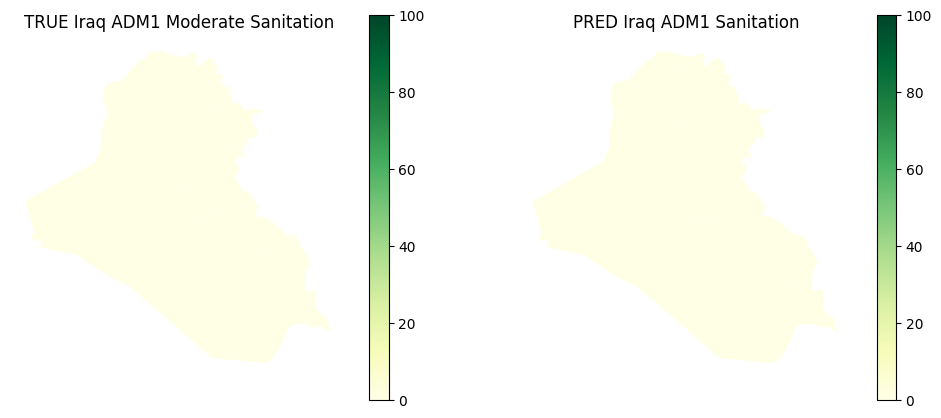

In [20]:
em.compare_irq_pred(pred_amd1, target, cmap=cmap, target_name = target_name)

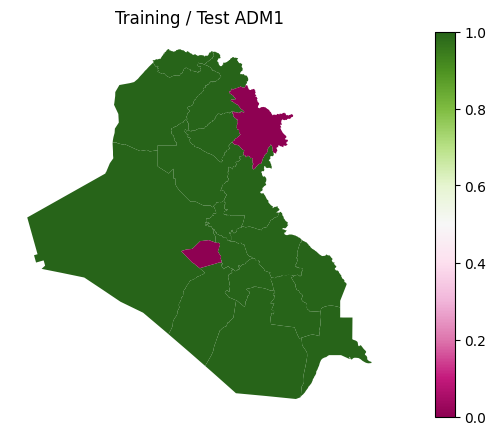

In [23]:
em.map_irq_training(pred_amd1)

# Predict

The file '../data/interim/IRQ_mosaiks_ADM2.csv' exists.
(101, 4002)
(101, 2)
(101, 4003)


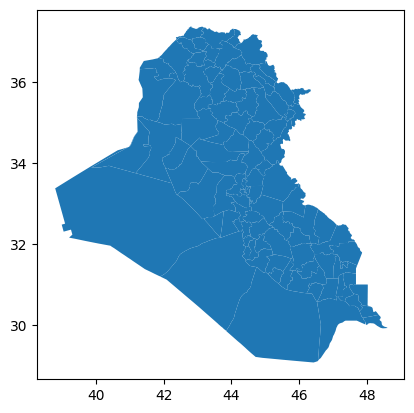

(101, 4003)


In [24]:
irq_adm2 = ld.adm2_for_country(cc='IRQ')
print(irq_adm2.shape)

In [25]:
irq_adm2['predictions'] = pm.predict_model(model, model_details, irq_adm2)

In [26]:
irq_adm2[irq_adm2['predictions'].isna()].shape

(0, 4004)

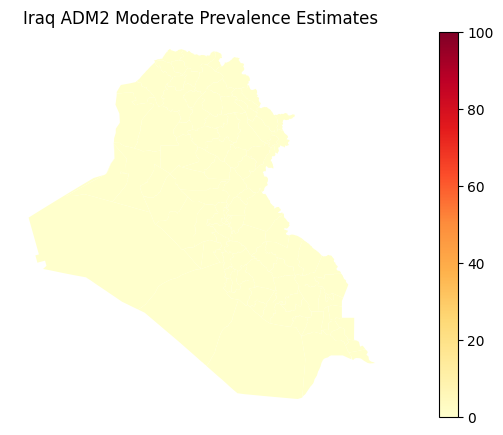

In [27]:
# Create a plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 5)) #, dpi=200)

# Plot ADM2 prevalence estimate
irq_adm2.plot(ax=ax, column='predictions', cmap='YlOrRd', legend=True, vmin = 0, vmax= 100)

plt.title(f'Iraq ADM2 Moderate Prevalence Estimates')
plt.axis('off')
plt.show()

In [28]:
irq_01x01 = pd.read_csv('../data/interim/mosaiks_irq_01x01.csv')

# Create a geometry column with Point geometries
geometry = [Point(lon, lat) for lon, lat in zip(irq_01x01['lon'], irq_01x01['lat'])]

# Create a GeoDataFrame from the DataFrame and geometry
irq_01x01 = gpd.GeoDataFrame(irq_01x01, geometry=geometry, crs='EPSG:4326')  # Assuming WGS 84 coordinate reference system

print(irq_01x01.shape)

(4217, 4004)


In [29]:
irq_01x01['predictions'] = pm.predict_model(model, model_details, irq_01x01)

In [30]:
irq_01x01['predictions'].isna().sum()


0

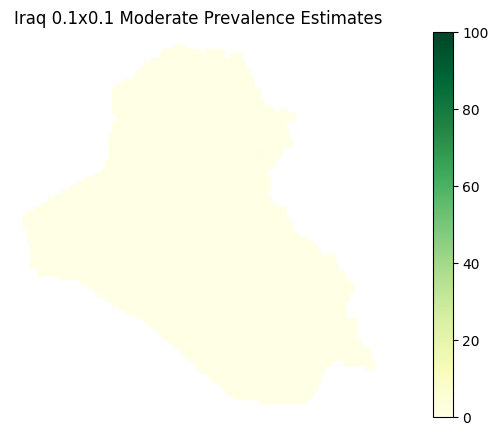

In [32]:
# Create a plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 5)) #, dpi=200)

# Plot ADM2 prevalence estimate
irq_01x01.plot(ax=ax, column='predictions', cmap=cmap, legend=True, vmin = 0, vmax= 100, marker = ',')

plt.title(f'Iraq 0.1x0.1 Moderate Prevalence Estimates')
plt.axis('off')
plt.show()